In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import preprocess as pp

'''
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
'''
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv1D, BatchNormalization, Dropout

In [2]:
# Loading all files 
train   = pd.read_csv(r"train.csv")
ratings = pd.read_csv(r"ratings.csv")
remarks = pd.read_csv(r"remarks.csv")
remarks_so = pd.read_csv(r"remarks_supp_opp.csv")

### Data Cleaning

In [3]:
# We first need to preprocess ratings, remarks and remarks_so files to incorporate their features into train and test files

### Preprocessing ratings.csv  ###
ratings_clean = pp.basic_clean(ratings)
pp.get_Ids(ratings_clean)
#calculate the mean of ratings given to a person
mean_ratings = ratings_clean.groupby('Id')['rating'].mean()
num_ratings = ratings_clean.groupby('Id')['rating'].count()

#Create a new rating = 0.90 X mean rating + 0.1 X num of ratings for a particular person
new_ratings = 0.85*pp.scale_matrix(np.matrix(mean_ratings)) + 0.15*pp.scale_matrix(np.matrix(num_ratings))
new_ratings = new_ratings.reshape(len(mean_ratings),1).astype(float).tolist()
new_ratings = [x[0] for x in new_ratings]

#extract a dictionary of ids against ratings
ratings_dict = dict(zip(mean_ratings.index.tolist(),new_ratings)) 

In [4]:
### Preprocessing remarks.csv ###
remarks_clean = pp.basic_clean(remarks)
pp.get_Ids(remarks_clean)
pp.txt_len(remarks_clean)

# get dictionary for mean remark length and no of comments
remark_len = remarks_clean.groupby('Id')['txt_length'].mean()
remark_num = remarks_clean.groupby('Id')['txt_length'].count()

# Create a dcitoinary for further use
rlen_dict = dict(zip(remark_len.index.tolist(),remark_len.tolist()))
rnum_dict = dict(zip(remark_num.index.tolist(),remark_num.tolist()))

In [5]:
## Preprocessing remarks_supp_opp.csv ###
rmso_clean = pp.basic_clean(remarks_so)
pp.get_Ids(rmso_clean) 
pp.encode_so(rmso_clean) # Sets 1 for True and 0 for False in support/oppose columns

# Get support or oppose for each id 
so_count = rmso_clean.groupby('Id')['support','oppose'].sum()

supp_dict = dict(zip(so_count.index.tolist(),so_count['support'].tolist()))
opp_dict  = dict(zip(so_count.index.tolist(),so_count['oppose'].tolist()))

In [6]:
X, y = pp.feature_engineer(data=train,
                        rt_dict=ratings_dict,
                        rlen_dict = rlen_dict,
                        rnum_dict = rnum_dict,
                        supp_dict=supp_dict,
                        opp_dict=opp_dict) 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000016741C45708>,
      dtype=object)

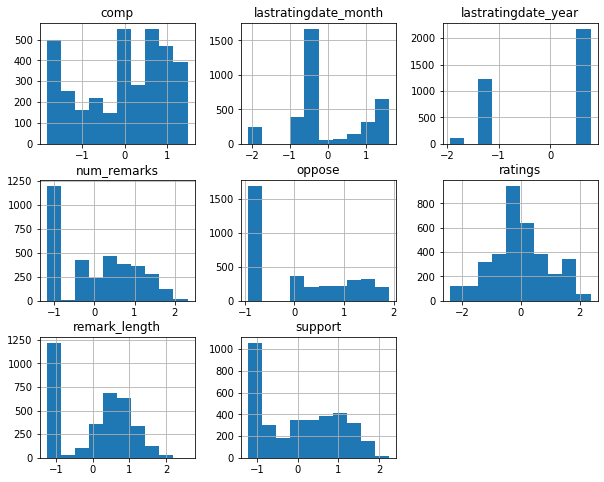

In [7]:
X.hist(figsize=(10,8))

In [8]:
# Using a model for classification
class_dict = {1:1,0: len(y[y==0])/len(y[y==1])}

rf_params = {   'n_estimators' : 150,
                'criterion' : 'entropy',
                'max_depth': None,                
                'max_features': None,
                'warm_start':False,
                'class_weight': class_dict,
                'random_state': 69 }

rf = RandomForestClassifier(**rf_params)

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
results = cross_val_score(rf,X,y,scoring='accuracy',cv=cv)
print("Test accuracy: ",results.mean())

NameError: name 'RandomForestClassifier' is not defined

In [10]:
rf.fit(X,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 4.936026936026936, 1: 1},
                       criterion='entropy', max_depth=None, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=69, verbose=0,
                       warm_start=False)

In [11]:
# Testing the model
test = pd.read_csv(r"test.csv")
test_ids = test['id']
test['left'] = np.zeros((len(test),1))
X_test, y_test = pp.InputPipeline(test,rt_dict=ratings_dict,supp_dict=supp_dict,opp_dict=opp_dict)

AttributeError: module 'preprocess' has no attribute 'InputPipeline'

In [37]:
y_pred = rf.predict(X_test)
submission = pd.DataFrame()
submission['id']   = test_ids
submission['left'] = y_pred
submission.to_csv("submissions_trial2.csv")

In [9]:
mean_ratings.min()

1.0

In [46]:
sum(new_ratings)/len(new_ratings)

0.5904752657723565

## Using a neural network for classification


In [57]:
### Building the model ###
num_features = len(X.columns)

class nn(Model):
    def __init__(self):
        super(nn,self).__init__()
        self.d1 = Dense(num_features,activation='relu')
        self.d2 = Dense(64,activation='relu')
        self.d3 = Dense(128,activation='relu')
        self.d4 = Dense(128,activation='relu')
        self.d5 = Dense(64,activation='relu')
        self.d6 = Dense(1,activation='softmax')

    def call(self,x):
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        x = self.d4(x)
        x = self.d5(x)
        return self.d6(x)

model = nn()

In [58]:
#model.summary()

In [59]:
### Setting loss metrics and optimizer ###
loss_object  = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [60]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name = 'test_accuracy')

In [61]:
@tf.function
def train_step(features,labels):
    with tf.GradientTape() as tape:
        predictions = model(features, training = True)
        loss = loss_object(labels,predictions)
    gradients = tape.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(gradients,model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels,predictions)

In [62]:
@tf.function
def test_step(features,models):
    predictions = model(features,training=False)
    t_loss = loss_object(labels,predictions)

    test_loss(t_loss)
    test_accuracy(labels,predictions)

In [63]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42)

In [64]:
### Loading data ###
train_ds = tf.data.Dataset.from_tensor_slices((X_train.values,y_train.values)).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((X_val.values,y_val.values)).batch(16)

In [65]:
### Running the model ###
EPOCHS = 100

for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for features, labels in train_ds:
        train_step(features,labels)

    for test_features, test_labels in test_ds:
        test_step(features,labels)

    template = "Epoch: {}/{}  Loss: {}  Accuracy: {}  Test loss: {}  Test Accuracy: {}"
    print(template.format(epoch+1, EPOCHS,
                            train_loss.result(),
                            train_accuracy.result()*100,
                            test_loss.result(),
                            test_accuracy.result()*100)) 


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch: 1/100  Loss: 1.1455366611480713  Accuracy: 16.772600173950195  Test loss: 1.3132622241973877  Test Accuracy: 0.0
Epoch: 2/100  Loss: 1.1455366611480713  Accuracy: 16.772600173950195  Test loss: 1.3132622241973877  Test Accuracy: 0.0
Epoch: 3/100  Loss: 1.1455366611480713  Accuracy: 16.772600173950195  Test loss: 1.3132622241973877  Test Accuracy: 0.0
Epoch: 4/100  Loss: 1.1455366611480713  Accuracy: 16.772600173950195  Test loss: 1.3132622241973877  Test Accuracy: 0.0
Epoch: 5/100  Loss: 1.145536